In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Set your project path 

import os
project_path =  '/content/drive/My Drive/Colab Notebooks/caps/'

In [0]:
os.chdir(project_path)

In [0]:
pwd


'/content/drive/My Drive/Colab Notebooks/caps'

In [0]:
ls


input_data.xlsx


In [0]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pandas import read_excel

df =  read_excel('./input_data.xlsx', 'Sheet1')
df.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [0]:
len(df)

8500

In [0]:
df.describe().transpose()

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


In [0]:
df.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

In [0]:
df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [0]:
## let us count the tickets by group

df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_73       1
GRP_67       1
GRP_70       1
GRP_61       1
Name: Assignment group, Length: 74, dtype: int64

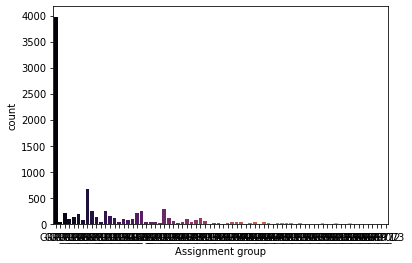

In [0]:
# Number of groups for overall ticker assignment using count plot
sns.countplot('Assignment group',data = df,palette='inferno')

Grp_0 has highest number of tickets assigned... 

In [0]:
### Description is missing for few of the tickets.. lets remove

In [0]:
df.isnull().values.any() ## Check for missing values

True

In [0]:
df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [0]:
# drop rows with missing values
df.dropna(inplace=True)

In [0]:
df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

In [0]:
df.shape

(8491, 4)

In [0]:
# dropping duplicate rows
df.drop_duplicates(keep=False,inplace=True)

In [0]:
df.shape

(8351, 4)

In [0]:
## Lets convert the description, short description, caller and group to lower case

df['Short description'] = df['Short description'].apply(lambda x: x.lower())
df['Description'] = df['Description'].apply(lambda x: x.lower())
df['Caller'] = df['Caller'].apply(lambda x: x.lower())
df['Assignment group'] = df['Assignment group'].apply(lambda x: x.lower())


In [0]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,grp_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,grp_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,grp_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0
4,skype error,skype error,owlgqjme qhcozdfx,grp_0


In [0]:
df.shape

(8351, 4)

In [0]:
# dropping duplicate rows.... in case case sensitive duplicates were present earlier
df.drop_duplicates(keep=False,inplace=True)

In [0]:
df.shape

(8351, 4)

In [0]:
df_copy = df.copy()

In [0]:
## Remove mail Ids from the fields
mailId = r'\S*@\S*\s?'
df = df.replace(to_replace=mailId, value='', regex=True)

In [0]:
## Combine short description and description
df['TicketDescription'] = df['Short description'].str.cat(df['Description'],sep=" ")

In [0]:
df = df.drop(['Short description', 'Description'], axis=1)

In [0]:
df = df.drop(['Caller'], axis=1) ## Delete the caller as well

In [0]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue -verified user details.(employee# ...
1,grp_0,outlook \r\n\r\nreceived from: \n\r\nhello tea...
2,grp_0,cant log in to vpn \r\n\r\nreceived from: \n\r...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [0]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue -verified user details.(employee# ...
1,grp_0,outlook \r\n\r\nreceived from: \n\r\nhello tea...
2,grp_0,cant log in to vpn \r\n\r\nreceived from: \n\r...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [0]:
## Decontract the words
import re
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [0]:
## To be tried out in next iternation... 
##df['TicketDescription'] = df['TicketDescription'].apply(lambda x: decontract(x))
## df.head()

In [0]:
## cleanup mail headers content 

def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['Subject:']
    regexList += ['[\r\n]']  # \r\n
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+'] ## Email Ids
    return regexList

In [0]:
def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset

In [0]:
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

In [0]:
columnsToClean = ['TicketDescription']
df = cleanDataset(df,columnsToClean, getRegexList())

In [0]:
df['TicketDescription'] = df['TicketDescription'].apply((lambda x: re.sub('[^a-zA-z0-9\s]',' ',x)))

In [0]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue verified user details employee ...
1,grp_0,outlook received from hello team m...
2,grp_0,cant log in to vpn received from hi ...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [0]:
## Clean stopwords and punctuations

import nltk
import string
import re

In [0]:
stopwords = nltk.corpus.stopwords.words('english')

def removeStopWordsPunctuations(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

df['TicketDescription'] = df['TicketDescription'].apply(lambda x: removeStopWordsPunctuations(x.lower()))

df.head()

,Assignment group,TicketDescription
0,grp_0,"[login, issue, verified, user, details, employ..."
1,grp_0,"[outlook, received, hello, team, meetings, sky..."
2,grp_0,"[cant, log, vpn, received, hi, cannot, log, vp..."
3,grp_0,"[unable, access, hrtool, page, unable, access,..."
4,grp_0,"[skype, error, skype, error, ]"


In [0]:
df.head()

,Assignment group,TicketDescription
0,grp_0,"[login, issue, verified, user, details, employ..."
1,grp_0,"[outlook, received, hello, team, meetings, sky..."
2,grp_0,"[cant, log, vpn, received, hi, cannot, log, vp..."
3,grp_0,"[unable, access, hrtool, page, unable, access,..."
4,grp_0,"[skype, error, skype, error, ]"


In [0]:
from nltk.stem.snowball import SnowballStemmer  ### Portstemmer vs snowballstemmer ... ?   Snowballstemmer is preferred over portstemmer for better results..

In [0]:
snowStem = nltk.SnowballStemmer("english")

In [0]:
def stemming(tokenized_text):
    text = [snowStem.stem(word) for word in tokenized_text]
    return text

df['TicketDescription'] = df['TicketDescription'].apply(lambda x: stemming(x))

df.head()

,Assignment group,TicketDescription
0,grp_0,"[login, issu, verifi, user, detail, employe, m..."
1,grp_0,"[outlook, receiv, hello, team, meet, skype, me..."
2,grp_0,"[cant, log, vpn, receiv, hi, cannot, log, vpn,..."
3,grp_0,"[unabl, access, hrtool, page, unabl, access, h..."
4,grp_0,"[skype, error, skype, error, ]"


In [0]:
## Lematizer to be tried out... Not sure if we need to do this... People prefere to do just stemming vs lemmatization... 
lemmatizer = WordNetLemmatizer()

def lematize_text(text):
  text = [lemmatizer.lemmatize(token, "v") for token in text] #Lemmatization
  return text

In [0]:
##df['TicketDescription'] = df['TicketDescription'].apply(lambda x: WordNetLemmatizer(x))
##df.head()

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [0]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
vocabSize = 20000
tokenizer = Tokenizer(num_words=vocabSize, split=' ')
tokenizer.fit_on_texts(df['TicketDescription'].values)
X = tokenizer.texts_to_sequences(df['TicketDescription'].values)
X = pad_sequences(X)

In [0]:
Y = pd.get_dummies(df['Assignment group']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7098, 1790) (7098, 74)
(1253, 1790) (1253, 74)


In [0]:
## Lets try out LSTM model

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(74,activation='softmax'))  ### Note that they are 74 groups to which tickets are to be assigned
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1790, 128)         2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1790, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 74)                14578     
Total params: 2,829,378
Trainable params: 2,829,378
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2)

Epoch 1/20
 - 1261s - loss: 2.4601 - accuracy: 0.4939
Epoch 2/20
 - 1251s - loss: 1.9476 - accuracy: 0.5579
Epoch 3/20
 - 1272s - loss: 1.7633 - accuracy: 0.5796
Epoch 4/20
 - 1286s - loss: 1.5909 - accuracy: 0.6078
Epoch 5/20
 - 1299s - loss: 1.4167 - accuracy: 0.6388
Epoch 6/20
 - 1305s - loss: 1.2675 - accuracy: 0.6669
Epoch 7/20
 - 1309s - loss: 1.1418 - accuracy: 0.6939
Epoch 8/20
 - 1313s - loss: 1.0242 - accuracy: 0.7175
Epoch 9/20
 - 1301s - loss: 0.9309 - accuracy: 0.7494
Epoch 10/20
 - 1307s - loss: 0.8386 - accuracy: 0.7706
Epoch 11/20
 - 1384s - loss: 0.7306 - accuracy: 0.7981
Epoch 12/20
 - 1358s - loss: 0.6590 - accuracy: 0.8221
Epoch 13/20
 - 1336s - loss: 0.5915 - accuracy: 0.8433
Epoch 14/20
 - 1358s - loss: 0.5311 - accuracy: 0.8566
Epoch 15/20
 - 1352s - loss: 0.4816 - accuracy: 0.8702
Epoch 16/20
 - 1361s - loss: 0.4293 - accuracy: 0.8812
Epoch 17/20
 - 1370s - loss: 0.3951 - accuracy: 0.8938
Epoch 18/20
 - 1373s - loss: 0.3551 - accuracy: 0.9032
Epoch 19/20
 - 1411

In [0]:
print('\nModel Performance: Log Loss and Accuracy on Test data')
print(model.evaluate(X_test, Y_test, batch_size = 1))


Model Performance: Log Loss and Accuracy on Test data
1253/1253 [==============================] - 214s 171ms/step
[1.9674391687932988, 0.6217079162597656]


In [0]:
### TBD
from sklearn import metrics

# Print the confusion matrix
##print(metrics.confusion_matrix(Y_test, y_pred))

# Print the precision and recall, among other metrics
##print(metrics.classification_report(Y_test, y_pred, digits=3))